In [1]:
from matplotlib import pyplot as plt
import cv
from matplotlib.image import imread
import pandas as pd
from collections import Counter
import json
import os
import re
import tempfile
import numpy as np
from os.path import exists
from imblearn.under_sampling import RandomUnderSampler
from PIL import ImageFile
import sklearn as sk
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# custom modules
import image_faults

ImageFile.LOAD_TRUNCATED_IMAGES = True

2022-08-01 22:09:35.958273: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [27]:
image_faults.faulty_images() # removes faulty images
df = pd.read_csv('expanded_class.csv', index_col=[0], low_memory=False)


In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1"])
#"/gpu:0",

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2022-08-01 22:09:39.570503: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-01 22:09:39.571048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-01 22:09:39.613420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 22:09:39.613584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.725GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-08-01 22:09:39.613631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA nod

In [4]:
def dict_pics_jup():
    '''
    {source:target} dict used to replace source urls with image location as input
    '''
    target_dir = os.getcwd() + os.sep + "training_images"
    with open('temp_pics_source_list.txt') as f:
        temp_pics_source_list = json.load(f)
        
    dict_pics = {}
    for k in temp_pics_source_list:
        try:      
             patt_1 = re.search(r'[^/]+(?=/\$_|.(\.jpg|\.jpeg|\.png))', k, re.IGNORECASE)
             patt_2 = re.search(r'(\.jpg|\.jpeg|\.png)', k, re.IGNORECASE)
             if patt_1 and patt_2 is not None:
                 tag = patt_1.group() + patt_2.group().lower()
                 file_name = target_dir + os.sep + tag
                 dict_pics.update({k:file_name})
        except TypeError:
            print(k)
    print("{source:target} dictionary created @ " + target_dir)
    return dict_pics


In [55]:
dict_pics = dict_pics_jup()

with open('women_cat_list.txt') as f:
    women_cats = json.load(f)
with open('men_cat_list.txt') as f:
    men_cats = json.load(f)
    
with open('temp_pics_source_list.txt') as f:
    tempics = json.load(f)
# list of image urls that did not get named properly which will be removed from the dataframe
drop_row_vals = []
for pic in tempics:
    try:
        dict_pics[pic]
    except KeyError:
        drop_row_vals.append(pic)

df['PrimaryCategoryID'] = df['PrimaryCategoryID'].astype(str) # pandas thinks ids are ints
df = df[df.PictureURL.isin(drop_row_vals)==False] # remove improperly named image files
df = df[df.PrimaryCategoryID.isin(men_cats)==False] # removes rows of womens categories

blah = pd.Series(df.PictureURL)
df = df.drop(labels=['PictureURL'], axis=1)

blah = blah.apply(lambda x: dict_pics[x])
df = pd.concat([blah, df],axis=1)
df = df.groupby('PrimaryCategoryID').filter(lambda x: len(x)>25) # removes cat outliers

nan
{source:target} dictionary created @ /home/unknown/Sync/projects/ebay ML Lister Project/training_images


In [78]:
df=df.sample(frac=1)
something = df.iloc[1,0]
something

'/home/unknown/Sync/projects/ebay ML Lister Project/training_images/7BQAAOSw0eZhpmqM.jpg'

In [60]:
undersample = RandomUnderSampler(sampling_strategy='auto')
train, y_under = undersample.fit_resample(df, df['PrimaryCategoryID'])
#print(Counter(train['PrimaryCategoryID']))

In [61]:
train, test = train_test_split(train, test_size=0.2, random_state=42)
# stratify=train['PrimaryCategoryID']
# train['PrimaryCategoryID'].value_counts()

In [80]:
datagen = ImageDataGenerator(rescale=1./255., 
                             validation_split=.2,
                             #samplewise_std_normalization=True,
                             #horizontal_flip= True,
                             #vertical_flip= True,
                             #width_shift_range= 0.2,
                             #height_shift_range= 0.2,
                             #rotation_range= 90,
                             preprocessing_function=tf.keras.applications.xception.preprocess_input)

train_generator=datagen.flow_from_dataframe(
    dataframe=train[:len(train)],
    directory='./training_images',
    x_col='PictureURL',
    y_col='PrimaryCategoryID',
    batch_size=56,
    seed=42,
    shuffle=True,
    target_size=(299,299),
    subset='training'
    )
validation_generator=datagen.flow_from_dataframe(
    dataframe=train[:len(train)], # is using train right?
    directory='./training_images',
    x_col='PictureURL',
    y_col='PrimaryCategoryID',
    batch_size=56,
    seed=42,
    shuffle=True,
    target_size=(299,299),
    subset='validation'
    )

/home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="PictureURL". These filename(s) will be ignored.
  warnings.warn(
/home/unknown/miniconda3/envs/tensorflow-cuda/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="PictureURL". These filename(s) will be ignored.
  warnings.warn(


Found 43744 validated image filenames belonging to 7 classes.
Found 10935 validated image filenames belonging to 7 classes.


In [81]:
imgs, labels = next(train_generator)

In [82]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

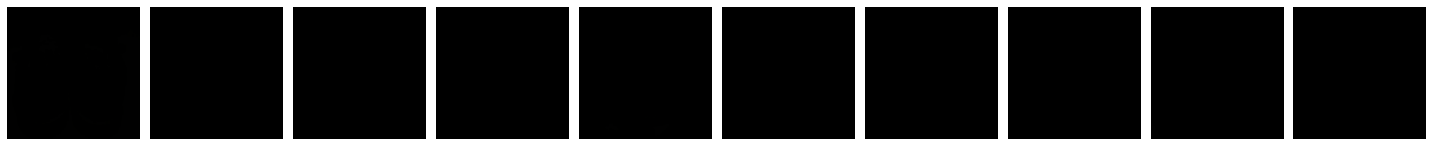

In [83]:
plotImages(imgs)
# image = plt.imread('training_images/0t0AAOSw4tNgSQ1j.jpg')
# plt.imshow(image)

In [84]:
#physical_devices = tf.config.list_physical_devices('GPU')
#print(len(physical_devices))
#print(physical_devices)
#for gpu_instance in physical_devices: 
#    tf.config.experimental.set_memory_growth(gpu_instance, True)
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [85]:
# see https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe for train/test/val split 
# example

# may need to either create a test dataset from the original dataset or just download a new one

In [86]:
with mirrored_strategy.scope(): # for training on dual gpus
#    physical_devices = tf.config.list_physical_devices('GPU')
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    base_model = tf.keras.applications.xception.Xception(include_top=True, pooling='avg')
    for layer in base_model.layers:
        layer.trainable = True
    output = Dense(7, activation='softmax')(base_model.output)
    model = tf.keras.Model(base_model.input, output)
    model.compile(optimizer=Adam(learning_rate=.001), loss='categorical_crossentropy',
              metrics=['accuracy'])
# sparse_categorical_crossentropy
#model = add_regularization(model)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [87]:

model.fit(x=train_generator,
          steps_per_epoch=len(train_generator),
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          epochs=6,
          verbose=1)

2022-08-01 23:37:26.275294: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_93447"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
    

Epoch 1/6
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
 17/782 [..............................] - ETA: 6:35 - loss: 1.9460 - accuracy: 0.1428

KeyboardInterrupt: 

In [ ]:
model.save("Model_1.h5")